## Washington oil EXPORT from Salish Sea facilities 
- Crude oil export counted if Delivered from a designated "Facility" (land-based)
- No ship-to-ship transfers included (yet).  This means that tanker volume estimates may be disproportionately higher than actual if tankers act as fueling hub for ATBs and tugs
- All non-ATBs and non-tugs are categorized tankers
- Oil volumes organized by vessel type and by fuel type
- 88.87% of all tanker, ATB, and barge volume exports to the selected refineries and terminals is accounted for using the specified oil type clasifications (see percent_check in Out[11])
-  Total Export in this analysis: 4,424,259,209 gallons of oil export (See printout above In[9])

### Known issues
- I need to convert to liters for our intents and purposes
- I don't yet know the proportion of fueling or cargo transfers that happens vessel-to-vessel as compared to from facility.  I think the best way for me to estimate this will be to add up all fueling and cargo received by tanker, tank barge and ATB and subtract the values from facility-only transfers to get the ship-to-ship transfers.  I presume the 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Documents/UBC/MIDOSS/Data/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

In [3]:
# Import columns are: (E) 'StartDateTime, (H) Receiver, (O) Region, (P) Product, (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', (W) Deliverer type 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="E,H,O,P,Q,R,W")

### Extract data for oil cargo transferred to vessels for marine export approximation

In [4]:
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]

In [5]:
oil_traffic = {}   

### Evaluate marine oil export

#### By vessel type 

In [6]:
# Eli Seely (DOE) reccomends using "Facility" in "DelivererTypeDescription"[W] to flag all refineries and terminals
#   and "Region"[O] (which is identified by county) to ID all non-Salish-Sea traffic
non_Salish_counties = ['Klickitat','Clark','Cowlitz','Wahkakum','Pacific','Grays Harbor']

In [7]:
# create dataset of export cargo in which export cargo is defined as 
# all cargo being transferred from (land-based) facility
cargo_export = cargo_data[cargo_data.DelivererTypeDescription.str.contains('Facility')]
    
# remove transfers from non-Salish-Sea locations
print('Removing oil transfers from: ')
for counties in non_Salish_counties:
    display(counties)
    cargo_export = cargo_export[~cargo_export.Region.str.contains(f'{counties}')]
    
# need to re-set indexing in order to use row-index as data_frame index
cargo_export.reset_index(drop=True, inplace=True)    

Removing oil transfers from: 


'Klickitat'

'Clark'

'Cowlitz'

'Wahkakum'

'Pacific'

'Grays Harbor'

In [8]:
# introduce dictionary for cargo traffic
oil_traffic['cargo'] = {}

# ATB fuel export
oil_traffic['cargo']['atb']                           = {}
oil_traffic['cargo']['atb']['percent_volume_export']  = {} # percentage of total crude export by oil type 
oil_traffic['cargo']['atb']['volume_export_total']    = 0
oil_traffic['cargo']['atb']['volume_export']          = [] # a vector of volumes ordered to pair with oil_type
oil_traffic['cargo']['atb']['oil_type']               = [] # a vector of oil types ordered to pair with volume_export

# barge fuel export
oil_traffic['cargo']['barge']                           = {}
oil_traffic['cargo']['barge']['percent_volume_export']  = {}
oil_traffic['cargo']['barge']['volume_export_total']    = 0
oil_traffic['cargo']['barge']['volume_export']          = []
oil_traffic['cargo']['barge']['oil_type']               = []

# tanker fuel export
oil_traffic['cargo']['tanker']                           = {}
oil_traffic['cargo']['tanker']['percent_volume_export']  = {}
oil_traffic['cargo']['tanker']['volume_export_total']    = 0
oil_traffic['cargo']['tanker']['volume_export']          = []
oil_traffic['cargo']['tanker']['oil_type']               = []

# total
oil_traffic['cargo']['export_total']                       = {}
oil_traffic['cargo']['export_total']['all']                = 0
oil_traffic['cargo']['export_total']['atb_barge_tankers']  = 0

# identify ship traffic 
[nrows,ncols] = cargo_export.shape

# total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
# create counter for vessel-type
atb_counter = 0
barge_counter = 0
tanker_counter = 0
for rows in range(nrows):
            
    # Add up all oil import to refineries and terminals, regardless of vessel-type
    oil_traffic['cargo']['export_total']['all'] += cargo_export.TransferQtyInGallon[rows]
    
    # ATB
    if 'ATB' in cargo_export.Receiver[rows]: 
        oil_traffic['cargo']['atb']['volume_export_total'] += cargo_export.TransferQtyInGallon[rows]
        oil_traffic['cargo']['atb']['volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['atb']['oil_type'] .append(cargo_export.Product[rows])
        atb_counter += 1
    
    # Barges
    elif ('BARGE' in cargo_export.Receiver[rows] or \
        'Barge'   in cargo_export.Receiver[rows] or \
        'PB'      in cargo_export.Receiver[rows] or \
        'YON'     in cargo_export.Receiver[rows] or \
        'DLB'     in cargo_export.Receiver[rows]): 
        oil_traffic['cargo']['barge']['volume_export_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['barge']['volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['barge']['oil_type'].append(cargo_export.Product[rows])
        barge_counter += 1
        #display(cargo_data.Receiver[rows])
    
    # Tankers
    else:
        oil_traffic['cargo']['tanker']['volume_export_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['tanker']['volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['tanker']['oil_type'].append(cargo_export.Product[rows])
        tanker_counter += 1
        #display(cargo_data.Receiver[rows])

oil_traffic['cargo']['export_total']['atb_barge_tankers'] = oil_traffic['cargo']['atb']['volume_export_total'] + oil_traffic['cargo']['barge']['volume_export_total'] + oil_traffic['cargo']['tanker']['volume_export_total']

atb_barge_tanker_percent = 100 * oil_traffic['cargo']['export_total']['atb_barge_tankers']/oil_traffic['cargo']['export_total']['all']
print('Volume of oil import captured by ATB, barge, and tank traffic used here: ' + str(atb_barge_tanker_percent) + '%')
print('Total Export in this analysis: ' + str(oil_traffic['cargo']['export_total']['all']) + ' gallons')

Volume of oil import captured by ATB, barge, and tank traffic used here: 100.0%
Total Export in this analysis: 4424259209 gallons


In [9]:
# Calculate percent of total transport by vessel type
atb_percent = 100*oil_traffic['cargo']['atb']['volume_export_total']/oil_traffic['cargo']['export_total']['all']
barge_percent = 100*oil_traffic['cargo']['barge']['volume_export_total']/oil_traffic['cargo']['export_total']['all']
tanker_percent = 100*oil_traffic['cargo']['tanker']['volume_export_total']/oil_traffic['cargo']['export_total']['all']
print(atb_percent)
print(barge_percent)
print(tanker_percent)

25.5842288286
3.0318680182
71.3839031532


Text(0.5,1,'Types of vessels by volume receiving oil as cargo from land-based facilities within the Salish Sea')

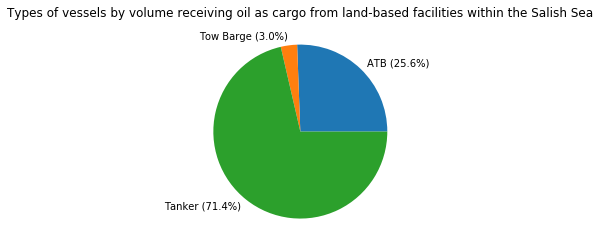

In [20]:
volume_export_byvessel = [oil_traffic['cargo']['atb']['volume_export_total'], oil_traffic['cargo']['barge']['volume_export_total'], oil_traffic['cargo']['tanker']['volume_export_total']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Tanker ({tanker_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(volume_export_byvessel, labels= labels)
plt.title('Types of vessels by volume receiving oil as cargo from land-based facilities within the Salish Sea')

#### By oil type within vessel type classification

In [11]:
oil_traffic['cargo']['atb']['CRUDE']=0
oil_traffic['cargo']['atb']['GASOLINE']=0
oil_traffic['cargo']['atb']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['atb']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['atb']['other']=0

oil_traffic['cargo']['barge']['CRUDE']=0
oil_traffic['cargo']['barge']['GASOLINE']=0
oil_traffic['cargo']['barge']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['barge']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['barge']['other']=0

oil_traffic['cargo']['tanker']['CRUDE']=0
oil_traffic['cargo']['tanker']['GASOLINE']=0
oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['tanker']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['tanker']['other']=0

oil_types = ['CRUDE', 'GASOLINE', 'JET FUEL/KEROSENE','DIESEL/MARINE GAS OIL', 
             'DIESEL LOW SULPHUR (ULSD)', 'BUNKER OIL/HFO', 'other']

percent_check = 0
for oil_name in range(len(oil_types)):
    
    # ATBs
    for rows in range(len(oil_traffic['cargo']['atb']['volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['atb']['oil_type'][rows]: 
            oil_traffic['cargo']['atb'][oil_types[oil_name]] += oil_traffic['cargo']['atb']['volume_export'][rows]
    
    # Barges
    for rows in range(len(oil_traffic['cargo']['barge']['volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['barge']['oil_type'][rows]: 
            oil_traffic['cargo']['barge'][oil_types[oil_name]] += oil_traffic['cargo']['barge']['volume_export'][rows]
    
    # Tankers (non-ATB or Barge)
    for rows in range(len(oil_traffic['cargo']['tanker']['volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['tanker']['oil_type'][rows]: 
            oil_traffic['cargo']['tanker'][oil_types[oil_name]] += oil_traffic['cargo']['tanker']['volume_export'][rows]
    
    # calculate percentages based on total oil cargo exports
    oil_traffic['cargo']['atb']['percent_volume_export'][oil_types[oil_name]]    = 100 * oil_traffic['cargo']['atb'][oil_types[oil_name]]/oil_traffic['cargo']['export_total']['all']
    oil_traffic['cargo']['barge']['percent_volume_export'][oil_types[oil_name]]  = 100 * oil_traffic['cargo']['barge'][oil_types[oil_name]]/oil_traffic['cargo']['export_total']['all']
    oil_traffic['cargo']['tanker']['percent_volume_export'][oil_types[oil_name]] = 100 * oil_traffic['cargo']['tanker'][oil_types[oil_name]]/oil_traffic['cargo']['export_total']['all']
    
    for name in ['atb', 'barge', 'tanker']:
        percent_check += oil_traffic['cargo'][f'{name}']['percent_volume_export'][oil_types[oil_name]]

percent_check        

88.406178780019133

#### Plot up ATB fuel types

Text(0.5,1,'Types of oil transport by volume for ATBs from WA refineries and terminals')

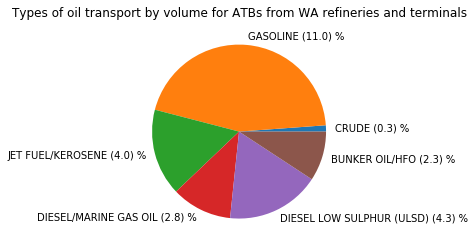

In [12]:
atb_volume_export = [oil_traffic['cargo']['atb']['CRUDE'],
                    oil_traffic['cargo']['atb']['GASOLINE'],
                    oil_traffic['cargo']['atb']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['atb']['BUNKER OIL/HFO']]
labels = []
for ii in range(len(oil_types)-1):
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["atb"]["percent_volume_export"][oil_types[ii]]:3.1f}) %')
    
plt.gca().axis("equal")
plt.pie(atb_volume_export, labels= labels)
plt.title('Types of oil transport by volume for ATBs from Salish Sea facilities')

#### Plot up Barge fuel types

Text(0.5,1,'Types of oil transport by volume for barges from WA refineries and terminals')

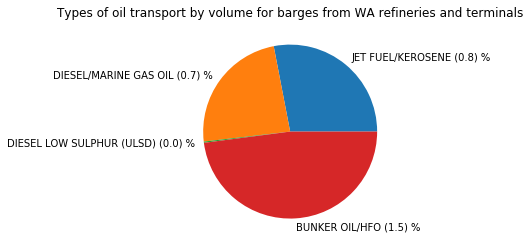

In [13]:
# barge_volume_export = [oil_traffic['cargo']['barge']['CRUDE'],
#                     oil_traffic['cargo']['barge']['GASOLINE'],
#                     oil_traffic['cargo']['barge']['JET FUEL/KEROSENE'],
#                     oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL'],
#                     oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)'],
#                     oil_traffic['cargo']['barge']['BUNKER OIL/HFO'],
#                     oil_traffic['cargo']['barge']['other']]
barge_volume_export = [oil_traffic['cargo']['barge']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['barge']['BUNKER OIL/HFO']]
labels = []
for ii in [2,3,4,5]:
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["barge"]["percent_volume_export"][oil_types[ii]]:3.1f}) %')

plt.gca().axis("equal")
plt.pie(barge_volume_export, labels= labels)
plt.title('Types of oil transport by volume for barges from Salish Sea facilities')

#### Plot up Tanker fuel types

Text(0.5,1,'Types of oil transport by volume for tankers from Salish Sea Facilities \n with percent of net crude export')

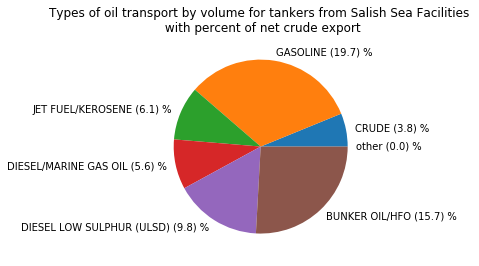

In [19]:
tanker_volume_export = [oil_traffic['cargo']['tanker']['CRUDE'],
                    oil_traffic['cargo']['tanker']['GASOLINE'],
                    oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['tanker']['BUNKER OIL/HFO'],
                    oil_traffic['cargo']['tanker']['other']]
labels = []
for ii in range(len(oil_types)):
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["tanker"]["percent_volume_export"][oil_types[ii]]:3.1f}) %')

plt.gca().axis("equal")
plt.pie(tanker_volume_export, labels= labels)
plt.title('Types of oil transport by volume for tankers from Salish Sea Facilities \n with percent of net crude export')

In [21]:
cargo_export

,StartDateTime,Receiver,Region,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription
0,2018-01-02 07:00:00,GLOBAL PILOT,KING,DIESEL/MARINE GAS OIL,546000,Cargo,Facility
1,2018-01-02 07:00:00,NATHAN SCHMIDT,WHATCOM,BUNKER OIL/HFO,1176000,Cargo,Facility
2,2018-01-02 01:00:00,ATB BARGE KIRBY 185-01,SKAGIT,BUNKER OIL/HFO,3150000,Cargo,Facility
3,2018-01-02 01:00:00,ATB BARGE KIRBY 185-01,SKAGIT,DIESEL/MARINE GAS OIL,3360000,Cargo,Facility
4,2018-01-03 02:00:00,CARTAGENA,SKAGIT,GASOLINE,7560000,Cargo,Facility
5,2018-01-01 00:01:00,PROFESSOR KAREN ANN BROWN,WHATCOM,DIESEL/MARINE GAS OIL,399000,Cargo,Facility
6,2018-01-01 21:00:00,ATB BARGE 550-2,WHATCOM,GASOLINE,3906000,Cargo,Facility
7,2018-01-02 12:00:00,ATB BARGE FIGHT FANCONI ANEMIA,WHATCOM,GASOLINE,1890000,Cargo,Facility
8,2018-01-02 12:00:00,ATB BARGE FIGHT FANCONI ANEMIA,WHATCOM,DIESEL/MARINE GAS OIL,1470000,Cargo,Facility
9,2018-01-02 08:00:00,NEW ENDEAVOR,MORROW,ETHANOL,425040,Cargo,Facility


#### This is the wrong way (includes ship-to-ship transfers)

In [15]:
# # remove cargo fuel transfers to land-based entity in order to isolate export cargo
# oil_traffic['cargo'] = {}
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refinery')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refining')] # this is specifically for U.S. Oil in Tacoma
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Terminal')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Petroleum')] # This is for smaller outfits, like Ranier Petroleum or Maxum Petrolem
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Inc')] # Covich, Petrocard
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('LLC')] # Pacific Functional Fluids, LLC; Coleman Oil Company, LLC
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Ballard Oil Co.')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Reisner Distributor, Inc.')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('NASWI')]

# # This dataset contains Columbia River locations that need to be scrubbed out
# cargo_data = cargo_data[~cargo_data.City.str.contains('vancouver')]

# # cargo_data is no longer indexed chronologically after removing 'Refinery', 'Terminal' and 'NASWI' entries
# # need to re-set indexing in order to use row-index as data_frame index
# cargo_data.reset_index(drop=True, inplace=True)
# [nrows,ncols] = cargo_data.shape

# # introduce dictionary entries for fuel volume export
# oil_traffic['cargo']['atb_volume_export']   = 0
# oil_traffic['cargo']['barge_volume_export'] = 0
# oil_traffic['cargo']['other_export'] = 0
# oil_traffic['cargo']['ship_to_ship'] = 0
# oil_traffic['cargo']['total']        = 0

# # carrier names
# oil_traffic['cargo']['atb_carrier']={}

# # total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
# for rows in range(nrows):
#     # from land-based terminals and refineries only
#     if 'Refinery' in cargo_data.Deliverer[rows] or 'Refining' in cargo_data.Deliverer[rows] or 'Terminal' in cargo_data.Deliverer[rows]: 
#         if 'ATB' in cargo_data.Receiver[rows] :
#             oil_traffic['cargo']['atb_volume_export'] = oil_traffic['cargo']['atb_volume_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#             #if cargo_data.Receiver[rows] not in oil_traffic['cargo']['atb_carrier']:
#             #    oil_traffic['cargo']['atb_carrier'][f'{oil_traffic['cargo']['atb_carrier']}']=[f'{oil_traffic['cargo']['atb_carrier']}']
#         elif 'BARGE' in cargo_data.Receiver[rows] or 'Barge' in cargo_data.Receiver[rows] or 'PB' in cargo_data.Receiver[rows] or 'YON' in cargo_data.Receiver[rows] or 'DLB' in cargo_data.Receiver[rows]:  # and not 'ATB' in cargo_data.Receiver[rows]:  
#             oil_traffic['cargo']['barge_volume_export'] = oil_traffic['cargo']['barge_volume_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#         else:
#             oil_traffic['cargo']['other_export'] = oil_traffic['cargo']['other_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#     else:
#         oil_traffic['cargo']['ship_to_ship'] = oil_traffic['cargo']['ship_to_ship'] + cargo_data.TransferQtyInGallon[rows]
        
# oil_traffic['cargo']['total'] = oil_traffic['cargo']['atb_volume_export'] + oil_traffic['cargo']['barge_volume_export'] + oil_traffic['cargo']['other_export'] + oil_traffic['cargo']['ship_to_ship']
# oil_traffic['cargo']['total']/cargo_data.TransferQtyInGallon.sum()

### Add up volume transferred by fuel type 

In [16]:
# Add up the total volume of marine transport by product (this includes all transfers)
gas_export_data    = cargo_data[cargo_data['Product']=='GASOLINE']
gas_export_total   = gas_export_data['TransferQtyInGallon'].sum()
gas_export_percent = 100*gas_export_total/cargo_data.TransferQtyInGallon.sum()

diesel_export_data    = cargo_data[cargo_data['Product']=='DIESEL/MARINE GAS OIL']
diesel_export_total   = diesel_export_data['TransferQtyInGallon'].sum()
diesel_export_percent = 100*diesel_export_total/cargo_data.TransferQtyInGallon.sum()

bunker_export_data  = cargo_data[cargo_data['Product']=='BUNKER OIL/HFO']
bunker_export_total = bunker_export_data['TransferQtyInGallon'].sum()
bunker_export_percent = 100*bunker_export_total/cargo_data.TransferQtyInGallon.sum()

jet_export_data   = cargo_data[cargo_data['Product']=='JET FUEL/KEROSENE']
jet_export_total  = jet_export_data['TransferQtyInGallon'].sum()
jet_export_percent = 100*jet_export_total/cargo_data.TransferQtyInGallon.sum()

ulsd_export_data  = cargo_data[cargo_data['Product']=='DIESEL LOW SULPHUR (ULSD)']
ulsd_export_total = ulsd_export_data['TransferQtyInGallon'].sum()
ulsd_export_percent = 100*ulsd_export_total/cargo_data.TransferQtyInGallon.sum()


crude_export_data  = cargo_data[cargo_data['Product'].str.contains('CRUDE')]
crude_export_total = crude_export_data['TransferQtyInGallon'].sum()
crude_export_percent = 100*crude_export_total/cargo_data.TransferQtyInGallon.sum()

Other_fuel_total = cargo_data['TransferQtyInGallon'].sum() - crude_export_total - ulsd_export_total - jet_export_total - bunker_export_total - diesel_export_total - gas_export_total 
other_fuel_percent = 100*Other_fuel_total/cargo_data.TransferQtyInGallon.sum()

total_percent = other_fuel_percent+crude_export_percent+ulsd_export_percent+jet_export_percent+bunker_export_percent+diesel_export_percent+gas_export_percent
total_percent

100.0

### Plot up results

Text(0.5,1,'Marine Oil Export from WA Refineries and Terminals')

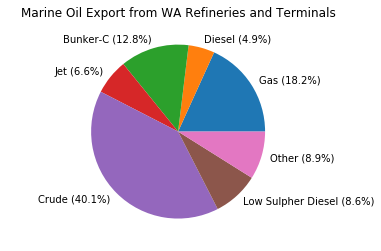

In [17]:
oil_export_values = [gas_export_total, diesel_export_total , bunker_export_total, jet_export_total, crude_export_total, ulsd_export_total, Other_fuel_total]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'Gas ({gas_export_percent:3.1f}%)', f'Diesel ({diesel_export_percent:3.1f}%)', f'Bunker-C ({bunker_export_percent:3.1f}%)', f'Jet ({jet_export_percent:3.1f}%)', f'Crude ({crude_export_percent:3.1f}%)', f'Low Sulpher Diesel ({ulsd_export_percent:3.1f}%)', f'Other ({other_fuel_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(oil_export_values, labels= labels)
plt.title('Marine Oil Export from WA Refineries and Terminals')

In [18]:
cargo_data

,StartDateTime,Receiver,Region,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription
1,2018-01-02 07:00:00,GLOBAL PILOT,KING,DIESEL/MARINE GAS OIL,546000,Cargo,Facility
2,2018-01-01 04:30:00,Phillips 66 Ferndale Refinery,WHATCOM,CRUDE OIL,12390000,Cargo,TANK SHIP
3,2018-01-02 07:00:00,NATHAN SCHMIDT,WHATCOM,BUNKER OIL/HFO,1176000,Cargo,Facility
4,2018-01-02 08:00:00,BP Cherry Point Refinery,WHATCOM,CRUDE OIL,8820000,Cargo,TANK SHIP
5,2018-01-01 07:00:00,SeaPort Sound Terminal,PIERCE,GASOLINE,966000,Cargo,TANK BARGE
6,2018-01-02 08:00:00,Shell Oil LP Seattle Distribution Terminal,KING,GASOLINE,1680000,Cargo,TANK BARGE
7,2018-01-02 01:00:00,ATB BARGE KIRBY 185-01,SKAGIT,BUNKER OIL/HFO,3150000,Cargo,Facility
8,2018-01-02 01:00:00,ATB BARGE KIRBY 185-01,SKAGIT,DIESEL/MARINE GAS OIL,3360000,Cargo,Facility
9,2018-01-03 02:00:00,CARTAGENA,SKAGIT,GASOLINE,7560000,Cargo,Facility
20,2018-01-01 00:01:00,PROFESSOR KAREN ANN BROWN,WHATCOM,DIESEL/MARINE GAS OIL,399000,Cargo,Facility
